Кейс №1 - Приложение знакомств

Вы работаете аналитиком в приложении для онлайн-знакомств. Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

Ваша задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

### Предварительный анализ данных

In [34]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import pingouin as pg
import statsmodels.api as sm

import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline


In [3]:
df_dating = pd.read_csv('dating_data.csv')

In [4]:
df_dating.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [5]:
df_dating.shape

(14514, 4)

In [6]:
df_dating.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [7]:
df_dating.groupby('group', as_index=False).agg({'is_match':['count', 'sum', 'mean']})

group is_match                
           count   sum      mean
0     0     4792   934  0.194908
1     1     9722  3909  0.402078

In [8]:
df_dating.groupby('group', as_index=False).agg({'user_id_1':'nunique', 'user_id_2':'nunique'})

,group,user_id_1,user_id_2
0,0,501,501
1,1,499,499


### Выводы:  
1. В данных не повторяются пары. 
2. Пользователи встречаются в двух колонках с айдишниками. 
3. Количество юзеров в каждой группе почти равны
4. Число пар больше в экспериментальной группе 
5. Буду считать, что колонка user_id_1 - пользователь, который поставил лайк первым, а user_id_2 поставил лайк вторым 

### Метрики

Первое что приходит в голову - это конверсия (число мэтчей, которое приходится на 1 пользователя деленное на число свайпов, но в нашем случе на общее число созданных пар).  
Буду подсчитывать количество мэтчей, когда юзер стоит в первой колонке, потом когда во второй, затем складывать.  
Второе, о чем я подумала - это число свайпов вправо, которое приходится на все свайпы. Но данной информации у нас нет( 
Думаю, что можно подсчитывать количество 

### Конверсия

In [9]:
df_dating.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [10]:
df_match_1 = df_dating.groupby(['group', 'user_id_1'], as_index=False).agg({'is_match': ['sum', 'count']})

In [11]:
df_match_1.droplevel(level=1, axis=1)
df_match_1.columns = ['group', 'user_id', 'match_1', 'all_match_1']

In [12]:
df_match_2 = df_dating.groupby(['group', 'user_id_2'], as_index=False).agg({'is_match': ['sum', 'count']})

In [13]:
df_match_2.columns = ['group', 'user_id', 'match_2', 'all_match_2']

In [14]:
df_match_1

,group,user_id,match_1,all_match_1
0,0,4,2,9
1,0,10,3,6
2,0,12,1,12
3,0,14,0,8
4,0,15,3,20
...,...,...,...,...
995,1,987,8,23
996,1,992,8,21
997,1,993,6,18
998,1,998,10,18


In [15]:
df_match = df_match_1.merge(df_match_2, on=['group', 'user_id'], how='inner')

In [16]:
df_match.head()

,group,user_id,match_1,all_match_1,match_2,all_match_2
0,0,4,2,9,1,8
1,0,10,3,6,3,14
2,0,12,1,12,1,8
3,0,14,0,8,0,8
4,0,15,3,20,3,12


In [17]:
df_match['CTR'] = (df_match.match_1 + df_match.match_2) / (df_match.all_match_1 + df_match.all_match_2) 

In [18]:
df_match['all_match'] = df_match.all_match_1 + df_match.all_match_2
df_match['match'] = df_match.match_1 + df_match.match_2

In [19]:
df_match = df_match.drop(['match_1', 'all_match_1', 'match_2', 'all_match_2'], axis=1)

In [20]:
df_match

,group,user_id,CTR,all_match,match
0,0,4,0.176471,17,3
1,0,10,0.300000,20,6
2,0,12,0.100000,20,2
3,0,14,0.000000,16,0
4,0,15,0.187500,32,6
...,...,...,...,...,...
995,1,987,0.414634,41,17
996,1,992,0.400000,35,14
997,1,993,0.439024,41,18
998,1,998,0.500000,36,18


### Нулевая гипотеза  
0) средние значения CTR равны в экспериментальной и контрольной группах  
1) альтернативная: средние значения CTR в выборках различаются 

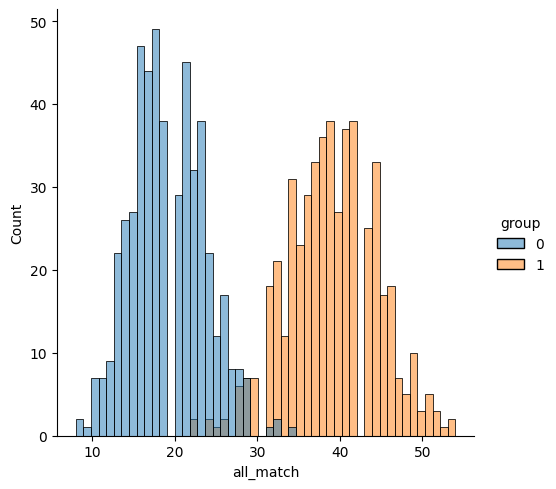

In [30]:
sns.displot(df_match, x='all_match', hue='group', bins=50)

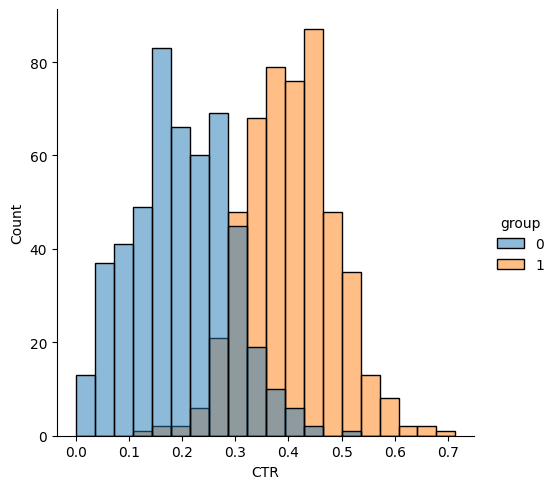

In [31]:
sns.displot(df_match, x='CTR', hue='group', bins=20)

In [22]:
pg.normality(df_match.query("group == 0"), method='normaltest').round(3)

,W,pval,normal
group,NaN,NaN,False
user_id,260.965,0.000,False
CTR,3.142,0.208,True
all_match,5.214,0.074,True
match,26.414,0.000,False


In [23]:
pg.normality(df_match.query("group == 1"), method='normaltest').round(3)

/Users/any_empty/Library/Python/3.11/lib/python/site-packages/scipy/stats/_stats_py.py:1580: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/any_empty/Library/Python/3.11/lib/python/site-packages/scipy/stats/_stats_py.py:1776: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)


,W,pval,normal
group,NaN,NaN,False
user_id,387.328,0.000,False
CTR,4.217,0.121,True
all_match,0.320,0.852,True
match,8.029,0.018,False


In [24]:
ss.levene(df_match.query("group == 0").CTR, df_match.query("group == 1").CTR)

LeveneResult(statistic=7.013821816267975, pvalue=0.008215929686873376)

### Вывод:  
Тесты показали, что распределение CTR является нормальным, но дисперсии различаются в двух выборка.

Хочется провести т-тест

In [33]:
pg.ttest(df_match.query("group == 0").CTR, df_match.query("group == 1").CTR)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-38.242658,987.842388,two-sided,4.415154e-197,"[-0.22, -0.2]",2.418173,3.171e+193,1.0


In [36]:
group_1 = np.array(df_match.query("group == 0").CTR)
group_2 = np.array(df_match.query("group == 1").CTR)

In [45]:
ss.bootstrap((group_1, group_2), statistic=)

TypeError: bootstrap() missing 1 required positional argument: 'statistic'